<a href="https://colab.research.google.com/github/MattRamb97/Erasmus_Hardgainers/blob/main/Recipes_model_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RECIPES MODEL**

We utilized the URLs provided to access the datasets stored in the folder https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/

using the pandas library. Subsequently, we identified an issue in the 'ingredients' column of the three datasets, characterized by the presence of the word 'ADVERTISEMENT', which we proceeded to remove. Additionally, we printed information regarding one of the datasets (the same information applies to the others) and their respective shapes.

In [ ]:
url_1 = 'https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/recipes_raw_nosource_ar.json'

import pandas as pd
df_ar = pd.read_json(url_1, orient='records', dtype='dict').transpose()
df_ar.info()
print()

df_ar = df_ar.dropna(subset=['title', 'ingredients', 'instructions', 'picture_link'])

df_ar['title'] = df_ar['title'].astype(str)

# Remove the word 'ADVERTISEMENT' from each text entry in the 'ingridients'
df_ar['ingredients'] = df_ar['ingredients'].astype(str).str.replace('ADVERTISEMENT', '',regex=True)

df_ar['instructions'] = df_ar['instructions'].astype(str)

print('From AR:', df_ar.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 39802 entries, rmK12Uau.ntP510KeImX506H6Mr6jTu to 2Q3Zpfgt/PUwn1YABjJ5A9T3ZW8xwVa
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39522 non-null  object
 1   ingredients   39522 non-null  object
 2   instructions  39522 non-null  object
 3   picture_link  39522 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB

From AR: (39802, 4)


Cleaning of the ingredients from numbers, units of measure and ( , ) , /

In [ ]:
import re

def clean_ingredients(ingredient):
    # Define the pattern to remove numbers, common units of measure, and unwanted characters including non-standard spaces
    pattern = r'\b\d+\.?\d*|\b(?:oz|ounce|ounces|lb|pound|pounds|g|gram|grams|kg|kilogram|kilograms|ml|milliliter|milliliters|l|liter|liters|tbsp|tbs|tablespoon|tablespoons|tsp|teaspoon|teaspoons|cup|cups|pinch|pinches)\b|[()\/]'
    # Replace the matched items with nothing (effectively removing them)
    cleaned_ingredient = re.sub(pattern, '', ingredient, flags=re.IGNORECASE)
    # Remove any kind of space-like characters and trim the string
    cleaned_ingredient = re.sub(r'\s+', ' ', cleaned_ingredient).strip()
    # Remove any invisible characters or non-breaking spaces
    cleaned_ingredient = re.sub(r'[\u200B-\u200D\uFEFF]', '', cleaned_ingredient)
    return cleaned_ingredient

# Apply the cleaning function to the ingredients column
df_ar['ingredients'] = df_ar['ingredients'].apply(clean_ingredients)

print(df_ar['ingredients'].iloc[1])

[' cans condensed cream of mushroom soup ', ' package dry onion soup mix ', ' water ', ' pot roast ', '']


We cleaned the three datasets using two function:
- uncontract(): expands contracted words commonly found in English sentences into their full forms using regular expressions.
- clean_recepies(): removes non-alphanumeric characters from the input text except for spaces and hyphens. It then replaces multiple spaces and hyphens with a single space and normalizes units of measurement (e.g., cups, tablespoons) by removing them. Next, it removes numerical digits, assuming they represent quantities. Finally, it normalizes whitespace by removing extra spaces and ensuring consistent spacing between words.

In [ ]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Create a formatting_func to structure training examples as prompts.

In [ ]:
def formatting_func(ingredients, title, instructions):
    text = f"### Ingredients: {ingredients}\n### Expected Output:\n### Title: {title}\n### Instructions: {instructions}"

    return text

Load Mistral - mistralai/Mistral-7B-v0.1

In [ ]:
!huggingface-cli login
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Set up the tokenizer. Add padding on the left as it makes training use less memory. For model_max_length, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(ingredients, title, instructions):
    return tokenizer(formatting_func(ingredients, title, instructions))

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Reformat the prompt and tokenize each sample

In [ ]:
tokenized_titles = []
tokenized_ingredients = []
tokenized_instructions = []

for ingredients, title, instructions in zip(df_ar['ingredients'].iloc[:200], df_ar['title'].iloc[:200], df_ar['instructions'].iloc[:200]):
    tokenized_ingredients.append(generate_and_tokenize_prompt( ingredients,title,instructions))
    tokenized_titles.append(generate_and_tokenize_prompt( ingredients,title, instructions))
    tokenized_instructions.append(generate_and_tokenize_prompt( ingredients,title, instructions))

Let's get a distribution of our dataset lengths, so we can determine the appropriate max_length for our input tensors.

400


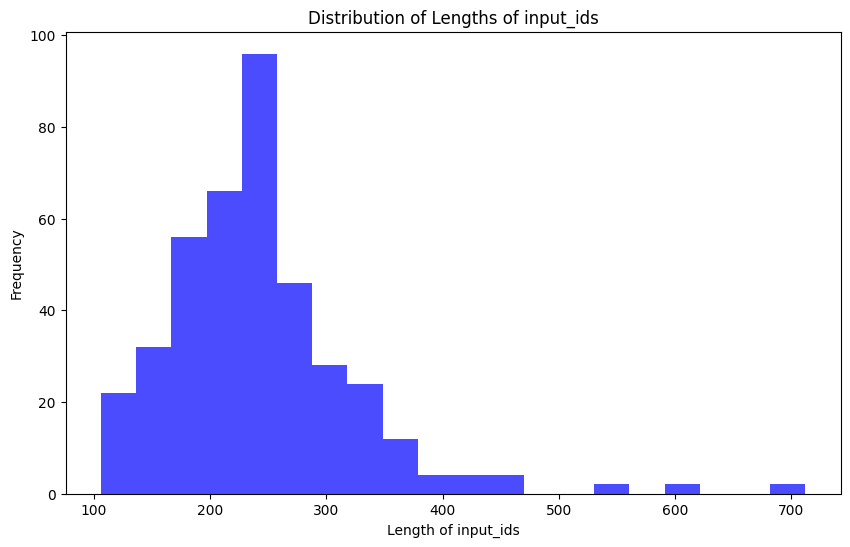

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_titles, tokenized_ingredients):
    lengths = [len(x['input_ids']) for x in tokenized_titles]
    lengths += [len(x['input_ids']) for x in tokenized_ingredients]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_titles, tokenized_ingredients)

In [ ]:
max_length = 350  # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(ingredients, title, instructions):

    ingredients_result = tokenizer(
        ingredients,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    title_result = tokenizer(
        title,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    instructions_result = tokenizer(
        instructions,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )

    ingredients_result["labels"] = ingredients_result["input_ids"].copy()
    title_result["labels"] = title_result["input_ids"].copy()
    instructions_result["labels"] = title_result["input_ids"].copy()

    return ingredients_result, title_result, instructions_result

# Tokenization of the dataset
tokenized_data = []
for ingredients, title, instructions in zip(df_ar['ingredients'].iloc[:200], df_ar['title'].iloc[:200], df_ar['instructions'].iloc[:200]):
    ingredients_result, title_result, instructions_result = generate_and_tokenize_prompt2(ingredients, title, instructions)
    # Concatenating results into a single input
    combined_input_ids = ingredients_result["input_ids"] + title_result["input_ids"] + instructions_result["input_ids"]
    combined_labels = ingredients_result["labels"] + title_result["labels"] +  instructions_result["labels"]
    tokenized_data.append({'input_ids': combined_input_ids, 'labels': combined_labels})

# Split data into training and evaluation datasets
split_index = int(0.8 * len(tokenized_data))
train_dataset = tokenized_data[:split_index]
eval_dataset = tokenized_data[split_index:]

In [ ]:
eval_prompt = f"### Ingredients: {ingredients}\n### Expected Output:\n### Title: {title}\n### Instructions: {instructions}"

# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Ingredients: [' all-purpose flour ', ' salt ', ' baking powder ', ' white sugar ', ' eggs ', ' warm milk ', ' butter, melted ', ' vanilla extract ', '']
### Expected Output:
### Title: Classic Waffles
### Instructions: In a large bowl, mix together flour, salt, baking powder and sugar; set aside. Preheat waffle iron to desired temperature.
In a separate bowl, beat the eggs. Stir in the milk, butter and vanilla. Pour the milk mixture into the flour mixture; beat until blended.
Ladle the batter into a preheated waffle iron. Cook the waffles until golden and crisp. Serve immediately.

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



---



**Set Up LoRA**

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the prepare_model_for_kbit_training method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj, and lm_head.

In [ ]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Here we define the LoRA config.

r is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

alpha is the scaling factor for the learned weights. The weight matrix is scaled by alpha/r, and thus a higher value for alpha assigns more weight to the LoRA activations.

The values used in the QLoRA paper were r=64 and lora_alpha=16, and these are said to generalize well, but we will use r=32 and lora_alpha=64 so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):



---



**TRAINING LoRA MODEL**

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

model = accelerator.prepare_model(model)

In [ ]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import transformers
from transformers import TrainingArguments, Trainer
from datetime import datetime
import torch

project = "recepies-model"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

# Initialize Trainer with your model and tokenizer
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir='./output',
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5,
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=25,
        evaluation_strategy="steps",
        eval_steps=25,
        do_eval=True,
        report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1463: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


wandb: Currently logged in as: matteo-rambaldi (recipes_model). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,3.163800,0.924942
50,0.829400,0.805467
75,0.770400,0.782979
100,0.587800,0.809995
125,0.534600,0.796577
150,0.584800,0.780885
175,0.472800,0.861545
200,0.370700,0.841884
225,0.368400,0.838734
250,0.316600,0.956170


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To main

TrainOutput(global_step=500, training_loss=0.4642612385749817, metrics={'train_runtime': 5096.1169, 'train_samples_per_second': 0.196, 'train_steps_per_second': 0.098, 'total_flos': 4.53329178624e+16, 'train_loss': 0.4642612385749817, 'epoch': 6.25})

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "output/checkpoint-300")

In [ ]:
eval_prompt = f"### Ingredients: {df_ar['ingredients'].iloc[57]}\n### Generate Title and Instructions:\n### Title:"

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    generated_texts = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True)
    print(generated_texts)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Ingredients: [' cans condensed cream of mushroom soup ', ' package dry onion soup mix ', ' water ', ' pot roast ', '']
### Generate Title and Instructions:
### Title: Slow Cooker Pot Roast
### Instructions:
1. In a slow cooker, combine the cream of mushroom soup, dry onion soup mix and water. Place the pot roast in the slow cooker, cover, and cook for 6 to 8 hours on High.
2. Remove meat from slow cooker, and place it on a cutting board. Slice thinly, and serve with cooking liquid.
3. Enjoy!

### References


In [ ]:
!pip install rouge_score

import matplotlib.pyplot as plt

def evaluate_and_plot(generated_text, reference_text):
    from datasets import load_metric
    bleu_metric = load_metric('bleu')
    rouge_metric = load_metric('rouge')
    meteor_metric = load_metric('meteor')

    predictions = [generated_text.split()]
    references = [[reference_text.split()]]

    # Compute metrics
    bleu_result = bleu_metric.compute(predictions=predictions, references=references)['bleu']
    rouge_result = rouge_metric.compute(predictions=predictions, references=references)['rouge1'].mid.fmeasure
    meteor_result = meteor_metric.compute(predictions=predictions, references=references)['meteor']

    # Prepare data for plotting
    metrics = ['BLEU', 'ROUGE-1', 'METEOR']
    scores = [bleu_result, rouge_result, meteor_result]

    # Plotting
    plt.figure(figsize=(8, 4))
    plt.bar(metrics, scores, color=['blue', 'green', 'red'])
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Evaluation Metrics')
    plt.ylim(0, 1)  # Assuming the scores are normalized between 0 and 1
    plt.show()

# Example generated and reference texts
reference_texts = f"Ingredients: {df_ar['ingredients'].iloc[57]} ### Expected Output: ### Title: {df_ar['title'].iloc[57]} ### Instructions: {df_ar['instructions'].iloc[57]}"
#f"### Ingredients: {df_ar['ingredients'].iloc[1]}\n### Generate Title and Instructions:\n### Title:{df_ar['title'].iloc[1]}\nInstrictions:{df_ar['instructions'].iloc[1]}"


# Generate plot
evaluate_and_plot(generated_texts, reference_texts)